### LSTM-based Recurrent Neural Network (RNN) to predict stock price

In [2]:
### Importing Required Libraries ###

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

In [3]:
#read the file
df = pd.read_csv(r"C:\Users\sanja\Desktop\DATA SCIENCE\sem 3\Mini project-AAI\BRITANNIA.csv")

#print the head
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,BRITANNIA,EQ,703.25,705.0,759.50,705.0,758.0,756.90,741.01,7512,5.566488e+11,NaN,NaN,NaN
1,2000-01-04,BRITANNIA,EQ,756.90,710.0,770.00,710.0,740.0,754.55,742.52,8135,6.040391e+11,NaN,NaN,NaN
2,2000-01-05,BRITANNIA,EQ,754.55,755.0,759.00,705.0,740.0,735.30,739.92,6095,4.509784e+11,NaN,NaN,NaN
3,2000-01-06,BRITANNIA,EQ,735.30,740.0,794.15,740.0,770.0,785.65,788.83,19697,1.553756e+12,NaN,NaN,NaN
4,2000-01-07,BRITANNIA,EQ,785.65,808.0,848.50,798.0,848.5,848.50,827.53,33107,2.739708e+12,NaN,NaN,NaN


In [4]:
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
5157,2020-09-24,BRITANNIA,EQ,3624.90,3590.0,3655.00,3560.20,3611.00,3612.75,3612.21,517316,1.868652e+14,38631.0,152823.0,0.2954
5158,2020-09-25,BRITANNIA,EQ,3612.75,3640.0,3716.95,3615.00,3703.75,3686.40,3668.71,507368,1.861385e+14,33389.0,133845.0,0.2638
5159,2020-09-28,BRITANNIA,EQ,3686.40,3710.9,3778.00,3689.00,3731.05,3737.35,3737.45,390640,1.459997e+14,23905.0,96348.0,0.2466
5160,2020-09-29,BRITANNIA,EQ,3737.35,3769.0,3796.00,3701.65,3715.05,3736.85,3756.82,449330,1.688051e+14,24309.0,126432.0,0.2814
5161,2020-09-30,BRITANNIA,EQ,3736.85,3734.0,3825.00,3714.05,3795.50,3798.15,3789.81,535771,2.030472e+14,32948.0,170100.0,0.3175


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5162 entries, 0 to 5161
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5162 non-null   object 
 1   Symbol              5162 non-null   object 
 2   Series              5162 non-null   object 
 3   Prev Close          5162 non-null   float64
 4   Open                5162 non-null   float64
 5   High                5162 non-null   float64
 6   Low                 5162 non-null   float64
 7   Last                5162 non-null   float64
 8   Close               5162 non-null   float64
 9   VWAP                5162 non-null   float64
 10  Volume              5162 non-null   int64  
 11  Turnover            5162 non-null   float64
 12  Trades              2313 non-null   float64
 13  Deliverable Volume  4653 non-null   float64
 14  %Deliverble         4653 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 605.0

Setting Date as Index. We will use **Close** Price for prediction

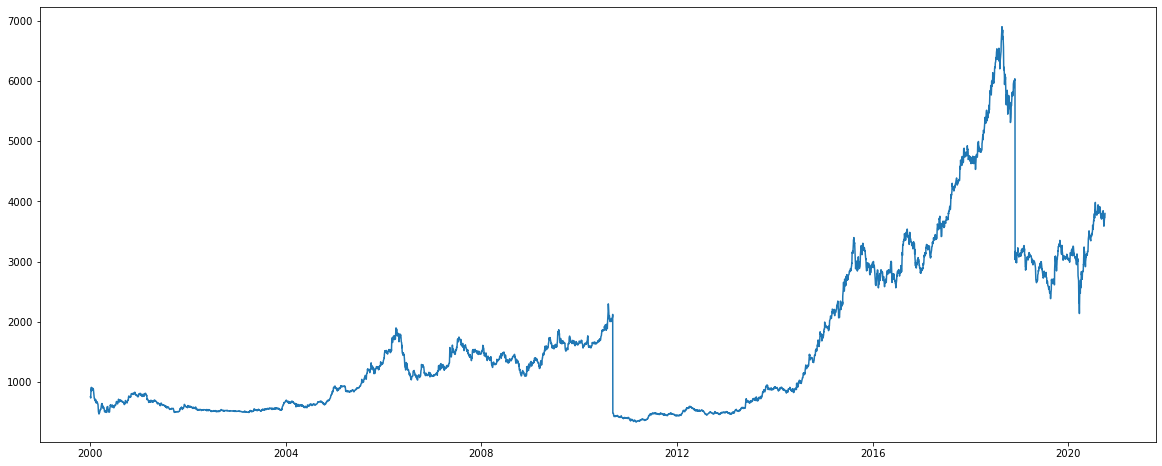

In [6]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(20,8))
plt.plot(df['Close'], label='Historical Close Price')

Selecting Close Price as feature and removing other columns from the data

In [7]:
features = ["Date", "Close"]
all_data = df[features]

In [8]:
#setting index
all_data.index = all_data.Date
all_data.drop('Date', axis=1, inplace=True)

C:\Users\sanja\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
all_data.head()

,Close
Date,
2000-01-03,756.90
2000-01-04,754.55
2000-01-05,735.30
2000-01-06,785.65
2000-01-07,848.50


In [10]:
all_data.shape

(5162, 1)

In [11]:
#creating training and validation sets
dataset = all_data.values

train = dataset[2000:4500,:]
valid = dataset[4500:,:]

### Feature Scaling

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

### Creating Sliding Window of 90 days

This data structure is needed to cover 90-days close price stamps, based on which RNN will predict the 91st day's close price. 

In [13]:
x_train, y_train = [], []
for i in range(90,len(train)):
    x_train.append(scaled_data[i-90:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#### Data Reshaping 

In [14]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Model Building

Initializing the LSTM model and 2nd, 3rd and 4th LSTM layer each with a Dropout Layer. The layers contain 50 neurons and with a Dropout rate of 20%, twenty percent of 50 neurons will be ignored randomly during each iteration

Finally, an output layer is added with 1 as an output dimension (as we are predicting the close price)

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(rate = 0.2))

model.add(Dense(1))

Compiling the model with **Stochastic Gradient Descent** algorithm 

Using Mean Squared Error as Loss Function

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
len(y_train)

2410

In [18]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
38/38 [==============================] - 8s 204ms/step - loss: 0.0015
Epoch 2/100
38/38 [==============================] - 7s 189ms/step - loss: 2.4485e-04
Epoch 3/100
38/38 [==============================] - 7s 186ms/step - loss: 2.0732e-04
Epoch 4/100
38/38 [==============================] - 7s 188ms/step - loss: 2.0568e-04
Epoch 5/100
38/38 [==============================] - 7s 189ms/step - loss: 2.0030e-04
Epoch 6/100
38/38 [==============================] - 7s 189ms/step - loss: 1.7603e-04
Epoch 7/100
38/38 [==============================] - 7s 193ms/step - loss: 1.7160e-04
Epoch 8/100
38/38 [==============================] - 6s 169ms/step - loss: 1.7324e-04
Epoch 9/100
38/38 [==============================] - 6s 160ms/step - loss: 1.6714e-04
Epoch 10/100
38/38 [==============================] - 6s 164ms/step - loss: 1.6257e-04
Epoch 11/100
38/38 [==============================] - 6s 162ms/step - loss: 1.3868e-04
Epoch 12/100
38/38 [==============================] - 6s

Epoch 95/100
38/38 [==============================] - 7s 193ms/step - loss: 5.4232e-05
Epoch 96/100
38/38 [==============================] - 7s 187ms/step - loss: 6.0643e-05
Epoch 97/100
38/38 [==============================] - 7s 189ms/step - loss: 5.8240e-05
Epoch 98/100
38/38 [==============================] - 7s 189ms/step - loss: 5.9975e-05
Epoch 99/100
38/38 [==============================] - 7s 190ms/step - loss: 5.9096e-05
Epoch 100/100
38/38 [==============================] - 7s 188ms/step - loss: 5.5622e-05


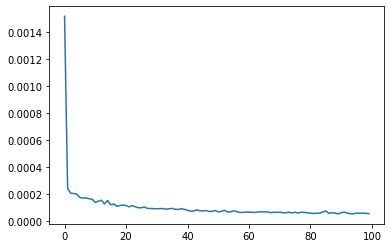

In [19]:
plt.plot(hist.history['loss'])

### Preparing the Test data for prediction

In [20]:
#predicting test data values, using past 90 from the train data
inputs = all_data[len(all_data) - len(valid)-90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [21]:
inputs.shape

(752, 1)

In [22]:
X_test = []
for i in range(90,inputs.shape[0]):
    X_test.append(inputs[i-90:i,0])
X_test = np.array(X_test)

In [23]:
X_test

array([[0.61734056, 0.61456016, 0.61164265, ..., 0.66592523, 0.67035863,
        0.6677382 ],
       [0.61456016, 0.61164265, 0.6081462 , ..., 0.67035863, 0.6677382 ,
        0.65347055],
       [0.61164265, 0.6081462 , 0.59934032, ..., 0.6677382 , 0.65347055,
        0.66360188],
       ...,
       [0.43126695, 0.43077181, 0.43937201, ..., 0.50101313, 0.49916207,
        0.51038271],
       [0.43077181, 0.43937201, 0.45505652, ..., 0.49916207, 0.51038271,
        0.51814498],
       [0.43937201, 0.45505652, 0.46352723, ..., 0.51038271, 0.51814498,
        0.5180688 ]])

In [24]:
X_test.shape

(662, 90)

In [25]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

In [26]:
preds

array([[4263.9243],
       [4260.55  ],
       [4244.909 ],
       [4235.6436],
       [4233.62  ],
       [4247.3604],
       [4267.087 ],
       [4258.5894],
       [4206.276 ],
       [4141.572 ],
       [4113.146 ],
       [4132.0874],
       [4204.071 ],
       [4290.045 ],
       [4346.489 ],
       [4362.831 ],
       [4338.641 ],
       [4296.0083],
       [4267.3916],
       [4282.4014],
       [4351.499 ],
       [4438.6567],
       [4498.2446],
       [4520.939 ],
       [4503.476 ],
       [4456.327 ],
       [4390.296 ],
       [4345.4795],
       [4330.7935],
       [4338.4897],
       [4360.8037],
       [4385.369 ],
       [4391.5527],
       [4387.988 ],
       [4381.45  ],
       [4366.5615],
       [4349.858 ],
       [4340.713 ],
       [4342.206 ],
       [4350.75  ],
       [4364.0317],
       [4399.0854],
       [4445.412 ],
       [4511.1753],
       [4572.5024],
       [4588.9976],
       [4570.7534],
       [4565.422 ],
       [4580.8276],
       [4598.1636],


### Calculating the RMSE to evaluate the model performance

In [27]:
rms=np.sqrt(np.mean(np.power((valid-preds),2)))
rms

441.2384048527682

### Plotting the output

<ipython-input-28-9109d7d841f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


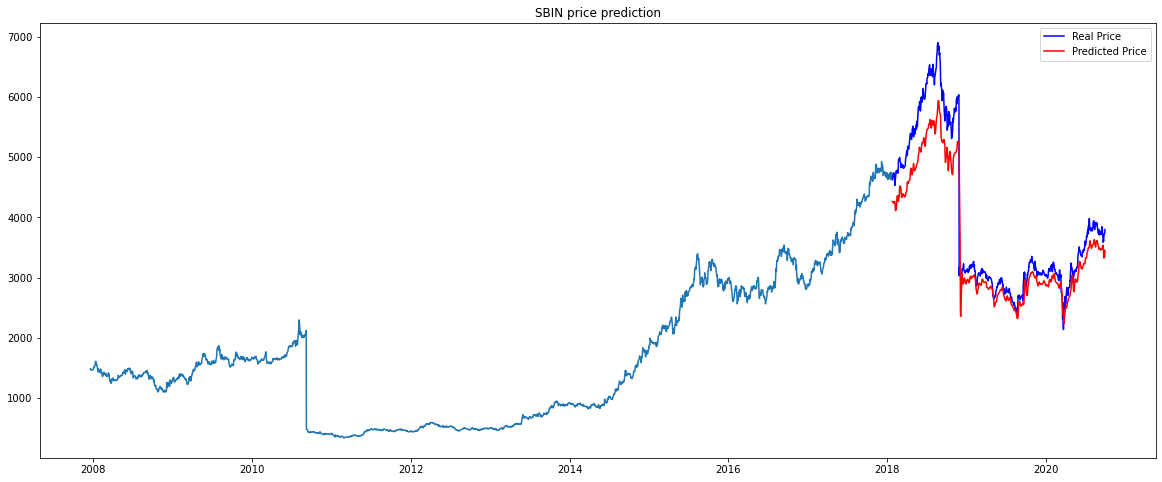

In [28]:
#for plotting
train = all_data[2000:4500]
valid = all_data[4500:]
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'blue', label = 'Real Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Price')
plt.title('SBIN price prediction')
plt.legend()
plt.show()